# PHQ2 Final Data Prep

In [ ]:
%matplotlib inline
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import synapseclient
from synapseclient import Activity, Schema, Table, as_table_columns

InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

### Get the data

In [ ]:
v1_raw_id, v2_raw_id = 'syn10250486', 'syn9974012'

v1r = pd.read_excel(syn.get(v1_raw_id).path)
v2r = pd.read_csv(syn.get(v2_raw_id).path, parse_dates=['createdAt'])

v1r.head()
v2r.head()

### Process V1 data

In [3]:
# drop the uneeded columns
v1r = v1r.drop(columns=[
    'sent_time_local', 'sent_time_utc', 'response_utc', 'response_id', 'user_id', 'start', 'phq2'
]).rename(columns={
    'brightenid': 'participant_id',
    'Feeling down, depressed, or hopeless.': 'phq2_1',
    'Little interest or pleasure in doing things.': 'phq2_2',
})

# add in yesterdays date
def dx(x):
    t = x-dt.timedelta(days=1)
    return dt.date(year=t.year, month=t.month, day=t.day)

v1r['dt_yesterday'] = v1r.response_local.apply(dx)

# add qsum
v1r['phq2_sum'] = [t.phq2_1 + t.phq2_2 for t in v1r.itertuples()]

### Process V2 Data

In [4]:
# rename some columns
v2r = v2r.rename(columns={
    'YESTERDAY, were you bothered by any of the following problems? Feeling down, depressed, or hopeless.':'phq2_1',
    'YESTERDAY, were you bothered by any of the following problems? Irritable or Anxious?':'phq2_2',
    'username':'participant_id',
    'createdAt': 'response_local'
})

# add yesterdays date
v2r['dt_yesterday'] = v2r.response_local.apply(dx)

# add qsum
v2r['phq2_sum'] = [t.phq2_1 + t.phq2_2 for t in v2r.itertuples()]

### Combine the DataFrames

In [ ]:
combined = pd.concat([v1r, v2r], sort=False)
combined = combined.loc[:,
    ['participant_id', 'response_local', 'dt_yesterday', 'day', 'phq2_1', 'phq2_2', 'phq2_sum']
].rename(columns={'response_local':'dt_response'})
combined.head()

1.0    16408
2.0    14255
3.0     9529
4.0     5142
5.0     2639
Name: phq2_1, dtype: int64

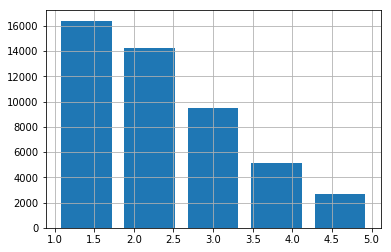

In [15]:
combined.phq2_1.hist(bins=5, rwidth=.8)
combined.phq2_1.value_counts()

1.0    16433
2.0    13799
3.0     9514
4.0     5182
5.0     3037
Name: phq2_2, dtype: int64

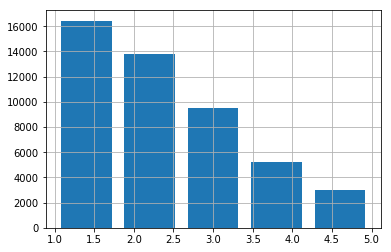

In [16]:
combined.phq2_2.hist(bins=5, rwidth=.8)
combined.phq2_2.value_counts()

### Set provevance and upload to Synapse

In [ ]:
phq2_final = syn.store(Table(
    Schema(
            name='Daily PHQ2 Survey',
            columns=as_table_columns(combined), 
            parent='syn10848316'),
        combined
    )
)

In [ ]:
phq2_final = syn.setProvenance(
    'syn17020855',
    activity=Activity(
        name='Combine V1 and V2 data',
        description='Process and combine the data collected during study 1 and study 2',
        used=[v1_raw_id, v2_raw_id],
        executed=[
            dict(
                name='IPython Notebook',
                url='https://github.com/apratap/BRIGHTEN-Data-Release/blob/master/Create_PHQ2_datafiles.ipynb'
            )
        ]
    )
)